# Importing the necesary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline
plt.style.use("seaborn-whitegrid")

# Reading in the dataset into memory

In [2]:
dataset=pd.read_csv("finalChallenge.csv")
display(dataset.sample(2))

,id,firstDate,repaidDate,settleDays,firstPaymentRatio,firstPaymentDefault,clientId,clientIncome,incomeVerified,clientAge,...,disbursementDate,payout_status,dueDate,paidAt,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,loanDefault
6462,303059319,2018-05-13 12:00:00 UTC,2018-06-29 10:25:22 UTC,47,0.0,1,545252174,109000.0,TRUE,26,...,4/13/2018,SUCCESS,2018-07-12 05:07:45 UTC,2018-09-21 06:18:43 UTC,45500,12.5,90,0,1,1
96739,3.01872E+11,2018-07-09 12:00:00 UTC,2018-07-10 07:29:25 UTC,1,0.0,0,201584256,105000.0,FALSE,46,...,6/8/2018,SUCCESS,2018-08-07 05:10:32 UTC,2018-07-11 06:36:29 UTC,15500,20.0,60,1,1,0


# Clean-up wrongly read-in filetypes

In [3]:
#converting from string the dateTime
dataset['firstDate']=pd.to_datetime(dataset['firstDate'])
dataset['repaidDate']=pd.to_datetime(dataset['repaidDate'],errors="coerce")
dataset["applicationDate"]=pd.to_datetime(dataset["applicationDate"],errors="coerce")
dataset["approvalDate"]=pd.to_datetime(dataset["applicationDate"],errors="coerce")
dataset["declinedDate"]=pd.to_datetime(dataset["applicationDate"],errors="coerce")
dataset["disbursementDate"]=pd.to_datetime(dataset["disbursementDate"],errors="coerce")
dataset["dueDate"]=pd.to_datetime(dataset["dueDate"],errors="coerce")
dataset["paidAt"]=pd.to_datetime(dataset["paidAt"],errors="coerce")


# converting from string to numeric data
dataset['clientAvgCallsPerDay']=pd.to_numeric(dataset['clientAvgCallsPerDay'],errors="coerce")
dataset['clientTimeAtEmployer'].apply(lambda number:number.replace("+",""))#replacing '+'with space for easy conversion to number e.g its impossible to parse 36+ as an integeer
dataset['clientTimeAtEmployer']=pd.to_numeric(dataset['clientTimeAtEmployer'],errors="coerce")
dataset['clientNumberPhoneContacts']=pd.to_numeric(dataset['clientNumberPhoneContacts'],errors="coerce")


print("Each column and their respective number of null values and data-type")
print(dataset.info())

Each column and their respective number of null values and data-type
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159596 entries, 0 to 159595
Data columns (total 34 columns):
id                           159596 non-null object
firstDate                    159596 non-null datetime64[ns]
repaidDate                   140125 non-null datetime64[ns]
settleDays                   159596 non-null int64
firstPaymentRatio            159596 non-null float64
firstPaymentDefault          159596 non-null int64
clientId                     159596 non-null int64
clientIncome                 159596 non-null float64
incomeVerified               159596 non-null object
clientAge                    159596 non-null int64
clientGender                 159596 non-null object
clientMaritalStatus          159596 non-null object
clientLoanPurpose            159596 non-null object
clientResidentialStauts      159596 non-null object
clientState                  159596 non-null object
clientTimeAtEmployer      

# Dropping of unnecessary and redundant features

In [4]:
# dropping of all forms of id's since it's unique and provides no insight into the data
dataset.drop('id',axis=1,inplace=True)
dataset.drop('clientId',axis=1,inplace=True)
dataset.drop("loanId",inplace=True,axis=1)

# dropping of redundant values
dataset.drop('payout_status',axis=1,inplace=True) #all values of 'payout_status' are "SUCCESS" thus the feature provides no insight
dataset.drop('loanType',axis=1,inplace=True) #all values of 'loan_type' are "paylater" thus the feature provides no insight
dataset.drop("paidAt",axis=1,inplace=True) #this is a feature leak as the target variable was derived from it
dataset.drop("settleDays",axis=1,inplace=True) #firstPaymentDefault is a representation of settleDays thus settledays is redundant
dataset.sample(2)

,firstDate,repaidDate,firstPaymentRatio,firstPaymentDefault,clientIncome,incomeVerified,clientAge,clientGender,clientMaritalStatus,clientLoanPurpose,...,approvalDate,declinedDate,disbursementDate,dueDate,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,loanDefault
5310,2018-08-27 12:00:00,2018-08-06 02:03:42,0.0,0,52500.0,FALSE,29,MALE,Single,other,...,2018-07-26,2018-07-26,2018-07-26,2018-10-24 03:41:27,17000,12.5,90,0,1,0
4886,2018-03-01 12:00:00,2018-03-30 11:11:27,0.0,1,25000.0,FALSE,33,MALE,Single,business,...,2018-01-30,2018-01-30,2018-01-30,2018-04-30 04:52:24,37500,10.0,90,1,1,1


In [5]:
case_one=(dataset['approvalDate']==dataset['declinedDate']).sum()
case_two=(dataset['applicationDate']==dataset['approvalDate']).sum()
case_three=(dataset['applicationDate']==dataset["disbursementDate"]).sum()

print("Number of cases in which approvalDate equals declinedDate is:{}.".format(case_one))

print("Number of cases in which applicationlDate equals approvalDate is:{}.".format(case_two))

print("Number of cases in which applicationlDate equals disbursementDate is:{}.".format(case_three))

print("As we can see in all cases approvalDate is equal to declineDate and applicationDate thus they are highly correlated features thus we maintain only one.")

print("ApplicationDate is equal to disbursementDate in {:.2f}% of all cases therefore they are highly correlated\n".format(case_three*100/case_two))

print("Therefore as shown above approvalDate,declinedDate,applicationDate and disbursementDate are all the same thing and thus redundant, so we drop all but applicationDate.")

# dropping repeated features
dataset.drop(['approvalDate',"declinedDate","disbursementDate","firstDate"],axis=1,inplace=True)

Number of cases in which approvalDate equals declinedDate is:159596.
Number of cases in which applicationlDate equals approvalDate is:159596.
Number of cases in which applicationlDate equals disbursementDate is:155654.
As we can see in all cases approvalDate is equal to declineDate and applicationDate thus they are highly correlated features thus we maintain only one.
ApplicationDate is equal to disbursementDate in 97.53% of all cases therefore they are highly correlated

Therefore as shown above approvalDate,declinedDate,applicationDate and disbursementDate are all the same thing and thus redundant, so we drop all but applicationDate.


# Handling of null values in the dataset

In [6]:
print("\t\t\t\tNumber of null values per column")
display(dataset.isnull().sum()) #display the sum of all null values per column

				Number of null values per column


repaidDate                   19471
firstPaymentRatio                0
firstPaymentDefault              0
clientIncome                     0
incomeVerified                   0
clientAge                        0
clientGender                     0
clientMaritalStatus              0
clientLoanPurpose                0
clientResidentialStauts          0
clientState                      0
clientTimeAtEmployer         91488
clientNumberPhoneContacts     2708
clientAvgCallsPerDay          2687
loanNumber                       0
applicationDate                  0
dueDate                          0
loanAmount                       0
interestRate                     0
loanTerm                         0
max_amount_taken                 0
max_tenor_taken                  0
loanDefault                      0
dtype: int64

###### There are some strings which are actually null valued but are read as 'Null' 
- so to parse them we replace every 'Null' in the dataset with np.nan

In [7]:
dataset=dataset.applymap(lambda x: np.nan if x=="Null" else x)
dataset.isnull().sum()

repaidDate                   19471
firstPaymentRatio                0
firstPaymentDefault              0
clientIncome                     0
incomeVerified                 103
clientAge                        0
clientGender                     0
clientMaritalStatus              6
clientLoanPurpose                0
clientResidentialStauts       1136
clientState                      1
clientTimeAtEmployer         91488
clientNumberPhoneContacts     2708
clientAvgCallsPerDay          2687
loanNumber                       0
applicationDate                  0
dueDate                          0
loanAmount                       0
interestRate                     0
loanTerm                         0
max_amount_taken                 0
max_tenor_taken                  0
loanDefault                      0
dtype: int64

###                                Drop columns which have more than 10% of their data missing since having  little data it  will be difficult to extract meaningfull information from them and filling them with 0.0 might provide a significant portion of our dataset with a wrong bias

In [8]:
# treshold means how many non-null values a column has to have not to be dropped in this case 60% of 159596
treshold=(90/100)*len(dataset)
initial_length=len(dataset.columns)

#drop columns not having at least {tresh} number of non-null values
filtered_dataset=dataset.dropna(axis=1,thresh=treshold) 
final_length=len(filtered_dataset.columns)

number_columns_dropped=initial_length-final_length
print("{} column{} dropped\n".format(number_columns_dropped,[" was","s were"][number_columns_dropped>1]))

display(filtered_dataset.isnull().sum())

2 columns were dropped



firstPaymentRatio               0
firstPaymentDefault             0
clientIncome                    0
incomeVerified                103
clientAge                       0
clientGender                    0
clientMaritalStatus             6
clientLoanPurpose               0
clientResidentialStauts      1136
clientState                     1
clientNumberPhoneContacts    2708
clientAvgCallsPerDay         2687
loanNumber                      0
applicationDate                 0
dueDate                         0
loanAmount                      0
interestRate                    0
loanTerm                        0
max_amount_taken                0
max_tenor_taken                 0
loanDefault                     0
dtype: int64

### As only two columns are left with null values we  fill their corresponding rows with the values ahead of them

In [9]:
#drop all the rows that contain a null value
filtered_dataset=filtered_dataset.fillna(method="ffill") 
display(filtered_dataset.isnull().sum())

firstPaymentRatio            0
firstPaymentDefault          0
clientIncome                 0
incomeVerified               0
clientAge                    0
clientGender                 0
clientMaritalStatus          0
clientLoanPurpose            0
clientResidentialStauts      0
clientState                  0
clientNumberPhoneContacts    0
clientAvgCallsPerDay         0
loanNumber                   0
applicationDate              0
dueDate                      0
loanAmount                   0
interestRate                 0
loanTerm                     0
max_amount_taken             0
max_tenor_taken              0
loanDefault                  0
dtype: int64

In [10]:
print("Our final dataset size is {}.".format(len(filtered_dataset)))
print("we removed {} of rows.".format(len(dataset)-len(filtered_dataset)))

Our final dataset size is 159596.
we removed 0 of rows.


### Our dataset is now free of null values

# Exploring our dataset

In [11]:
# display a random sample from our dataset
filtered_dataset.sample(2)

,firstPaymentRatio,firstPaymentDefault,clientIncome,incomeVerified,clientAge,clientGender,clientMaritalStatus,clientLoanPurpose,clientResidentialStauts,clientState,...,clientAvgCallsPerDay,loanNumber,applicationDate,dueDate,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,loanDefault
149101,0.0,0,35000.0,FALSE,28,MALE,Single,business,Rented,KANO,...,92.607843,4,2018-05-30,2018-08-28 06:24:26,22000,12.5,90,0,1,0
25998,0.0,1,280000.0,FALSE,28,MALE,Single,business,Rented,LAGOS,...,33.022222,2,2018-05-03,2018-07-02 07:18:37,40000,10.0,60,1,1,1


In [12]:
# statistical information about our groups
filtered_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
firstPaymentRatio,159596.0,0.097991,0.278058,0.0,0.000000,0.000000,0.000000,1.0
firstPaymentDefault,159596.0,0.294268,0.455714,0.0,0.000000,0.000000,1.000000,1.0
clientIncome,159596.0,90839.055766,97280.332866,30.0,35000.000000,55116.210000,105000.000000,3925000.0
clientAge,159596.0,33.691847,7.180870,18.0,28.000000,33.000000,38.000000,138.0
clientNumberPhoneContacts,159596.0,1261.253709,1522.033952,0.0,429.000000,824.000000,1549.000000,60595.0
clientAvgCallsPerDay,159596.0,59.073692,101.732522,0.0,9.882959,29.392717,70.010285,10994.5
loanNumber,159596.0,3.556806,2.471578,1.0,2.000000,3.000000,4.000000,32.0
loanAmount,159596.0,35324.184190,27840.824297,11000.0,20000.000000,25500.000000,37500.000000,500000.0
interestRate,159596.0,13.331235,4.467938,4.5,10.000000,12.500000,15.000000,20.0
loanTerm,159596.0,85.385599,39.323756,60.0,60.000000,60.000000,90.000000,180.0


## Exploring patterns observed by different genders

MALE      109666
FEMALE     49930
Name: clientGender, dtype: int64

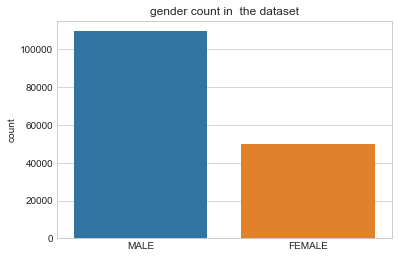

In [14]:
clientGender=pd.value_counts(dataset['clientGender'])
display(clientGender)

sns.barplot(clientGender.index,clientGender.values)
plt.title("gender count in  the dataset")
plt.ylabel("count")
plt.show()

In [15]:
genderGroup=filtered_dataset.groupby("clientGender")

##### sum of loan payment defaulters according to gender

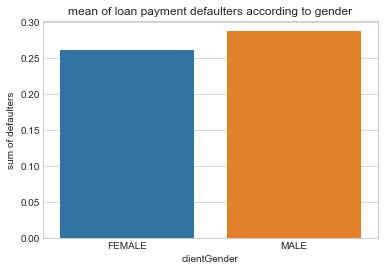

In [16]:
firstPaymentDefaultByGender=genderGroup["loanDefault"].mean()
sns.barplot(firstPaymentDefaultByGender.index,firstPaymentDefaultByGender.values)
plt.title("mean of loan payment defaulters according to gender")
plt.ylabel("sum of defaulters")
plt.show()

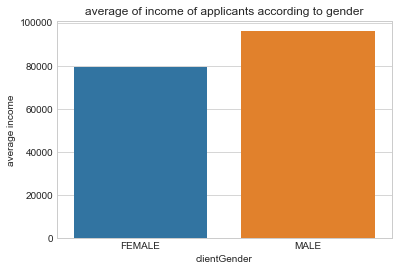

In [17]:
averageIncomeByGender=genderGroup["clientIncome"].mean()
sns.barplot(averageIncomeByGender.index,averageIncomeByGender.values)
plt.title("average of income of applicants according to gender")
plt.ylabel("average income")
plt.show()

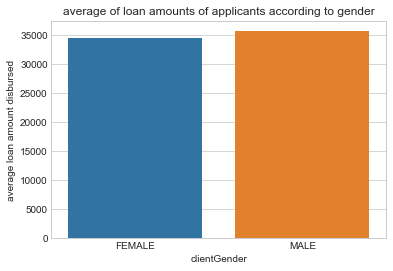

In [18]:
loanAmountByGender=genderGroup["loanAmount"].mean()
sns.barplot(loanAmountByGender.index,loanAmountByGender.values)
plt.title("average of loan amounts of applicants according to gender")
plt.ylabel("average loan amount disbursed")
plt.show()

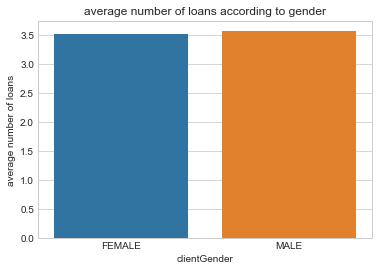

In [19]:
loanNumberByGender=genderGroup["loanNumber"].mean()
sns.barplot(loanNumberByGender.index,loanNumberByGender.values)
plt.title("average number of loans according to gender")
plt.ylabel("average number of loans")
plt.show()

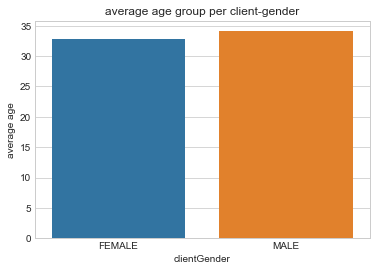

In [20]:
meanAge=genderGroup['clientAge'].mean()
sns.barplot(meanAge.index,meanAge.values)
plt.title("average age group per client-gender")
plt.ylabel("average age")
plt.show()

### Males appear to dominate in different loan features

## Observing patterns based on client loan purpose

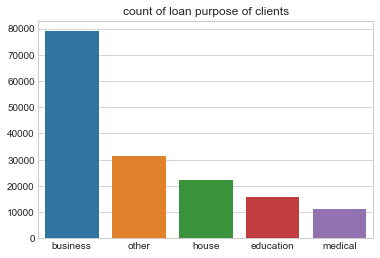

In [21]:
# counting the purpose of loan as given by clients
loanPurpose=pd.value_counts(filtered_dataset['clientLoanPurpose'])
sns.barplot(loanPurpose.index,loanPurpose.values)
plt.title("count of loan purpose of clients")
plt.show()

In [22]:
# grouping the  clients by their purpose
loanPurposeGroup=filtered_dataset.groupby("clientLoanPurpose")

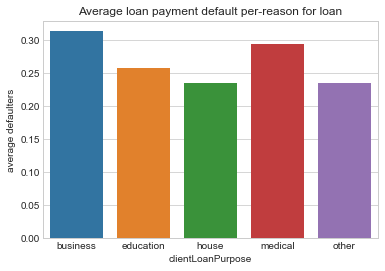

In [23]:
purposeLoanPaymentDefault=loanPurposeGroup['loanDefault'].mean();
sns.barplot(purposeLoanPaymentDefault.index,purposeLoanPaymentDefault.values);
plt.title("Average loan payment default per-reason for loan");
plt.ylabel("average defaulters");
plt.show();

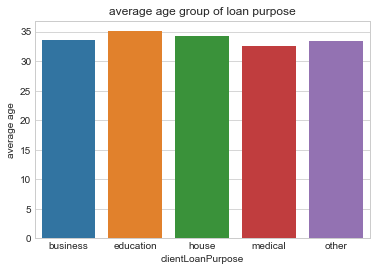

In [24]:
averageAgeperPurpose=loanPurposeGroup["clientAge"].mean()
sns.barplot(averageAgeperPurpose.index,averageAgeperPurpose.values)
plt.title("average age group of loan purpose")
plt.ylabel("average age")
plt.show()

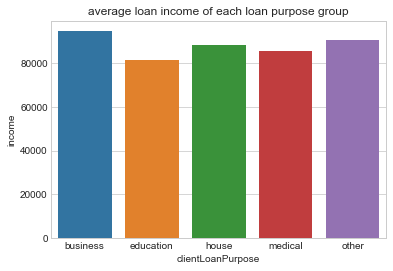

In [25]:
incomePerPurpose=loanPurposeGroup['clientIncome'].mean()
sns.barplot(incomePerPurpose.index,incomePerPurpose.values)
plt.ylabel("income")
plt.title("average loan income of each loan purpose group")
plt.show()

### distribution of clients across the country

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


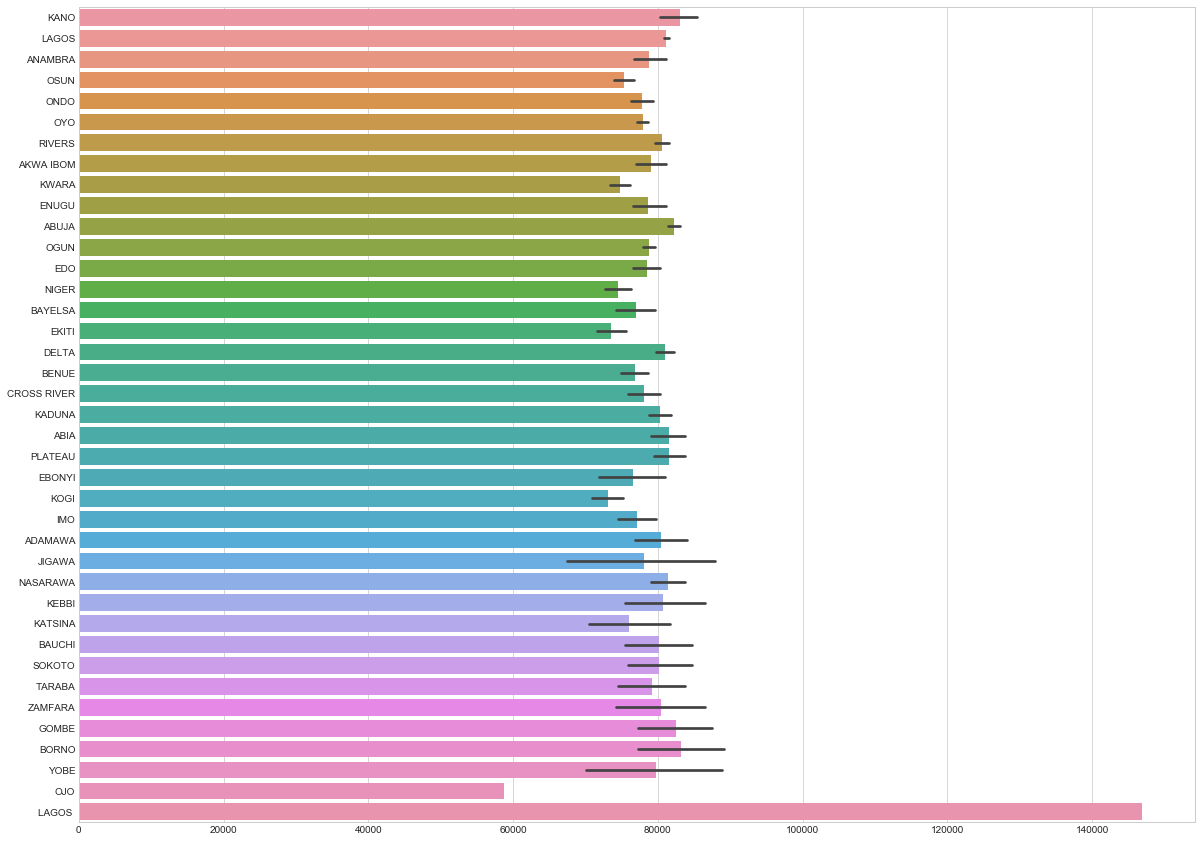

In [26]:
fig, ax = plt.subplots(figsize=(20,15))
locationDistribution=filtered_dataset['clientState']
sns.barplot(locationDistribution.index,locationDistribution.values)
plt.show()

#### average loan payment defaulters per location

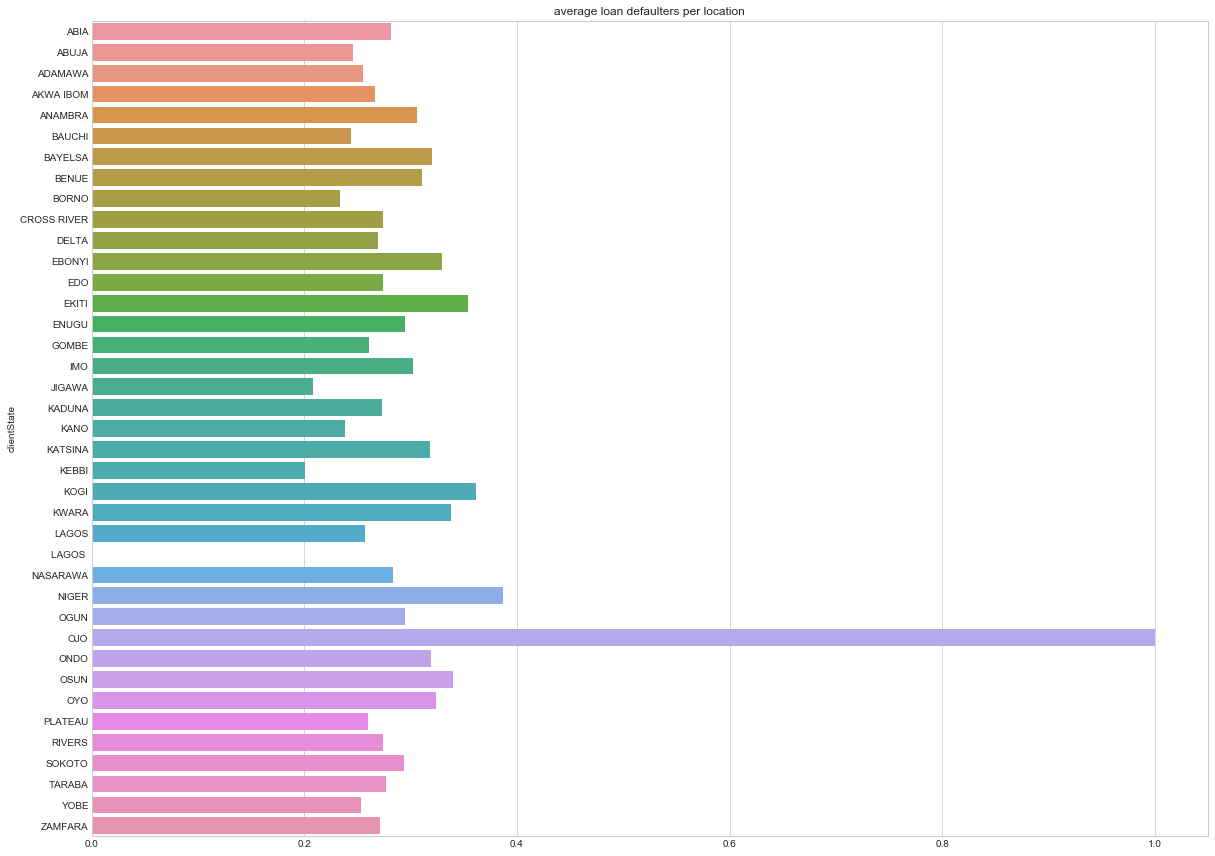

In [27]:
# group the dataset by the client state and find the average loan defaulters
fig, ax = plt.subplots(figsize=(20,15))
locationDefaultGroup=filtered_dataset.groupby('clientState')['loanDefault'].mean()
sns.barplot(locationDefaultGroup.values,locationDefaultGroup.index,orient="h")

plt.title("average loan defaulters per location")
plt.show()


### based on the data above our major client base is located in lagos

# Dividing the dataset into clusters

In [28]:
# get only the numeric values from the dataset
numeric_dataset= filtered_dataset.select_dtypes(include=['Int64','float64'])

### correlation heat-map of several features

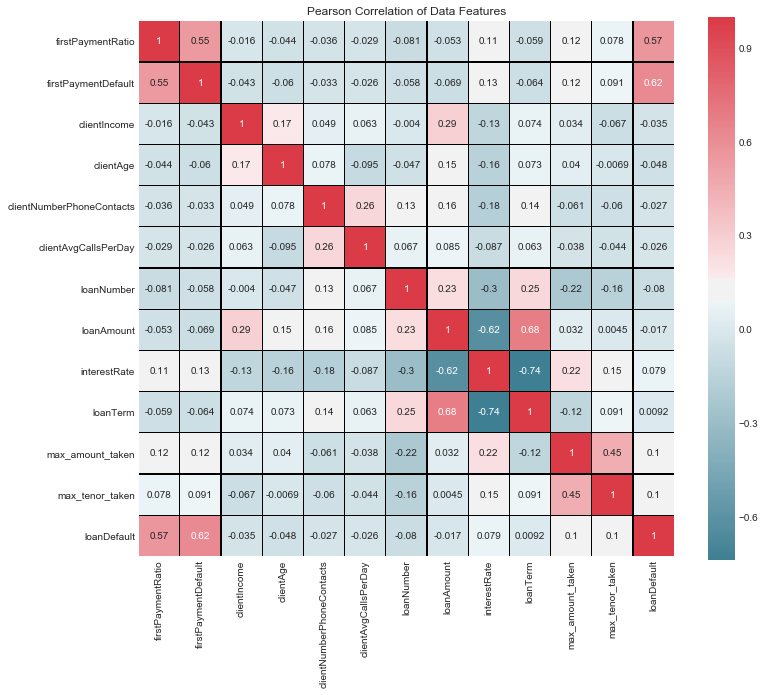

In [29]:
# check correlation of numeric features
f, ax = plt.subplots(figsize=(12,10))
plt.title('Pearson Correlation of Data Features')
sns.heatmap(numeric_dataset.corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax, linecolor='black', annot=True);

In [30]:
# scaling the numeric dataset
x=numeric_dataset.values
x_scaled=StandardScaler().fit_transform(x)
print(x_scaled.mean(axis=0).round(2))
print("As we can see the means are all zeros")

[ 0.  0.  0. -0.  0. -0.  0. -0. -0.  0. -0. -0.  0.]
As we can see the means are all zeros


In [31]:
# perform PCA on the dataset and include only the first two principal components
pca=PCA(n_components=2)

principal_components=pca.fit_transform(x_scaled)

print(principal_components.shape)

(159596, 2)


In [32]:
# create a dataframe for the principal components
pca_df=pd.DataFrame(principal_components,columns=["principal_component1","principal_component2"])
display(pca_df.head())

,principal_component1,principal_component2
0,-0.983775,-1.401193
1,0.802639,-1.249936
2,-1.395887,0.736586
3,-0.473648,-1.101372
4,-1.376341,1.146693


In [33]:
# the variance ratio captured by the first two components
pca.explained_variance_ratio_

array([0.21839879, 0.16171246])

In [34]:
# the sum of the variance ratio
total_variance_ratio=pca.explained_variance_ratio_.sum()
print("the total  explained ratio is:",total_variance_ratio)

the total  explained ratio is: 0.38011124571845123


## using sklearn's kmeans to cluster the pca dataframe

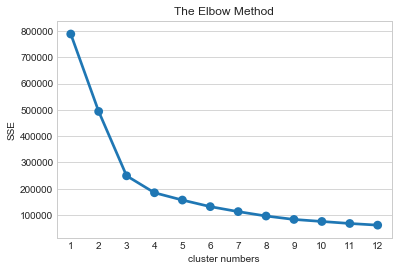

In [35]:
# use the elbow method to confirm that 2 clusters are optimal
err = {}
# Fit KMeans and calculate SSE for each k
for n_cluster in range(1, len(numeric_dataset.columns)):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=n_cluster, random_state=1024)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(principal_components)
    
    # Assign sum of squared distances to k element of dictionary
    err[n_cluster] = kmeans.inertia_

    
    
# Plot sum of square error for the different cluster sizes
plt.title('The Elbow Method')
plt.xlabel('cluster numbers')
plt.ylabel('SSE')
sns.pointplot(x=list(err.keys()), y=list(err.values()))
plt.show()

#### from the elbow method the optimal number of clusters is 3

In [36]:
model=KMeans(n_clusters=3)
clusters=model.fit_predict(principal_components)
print(clusters)

[0 0 2 ... 1 1 0]


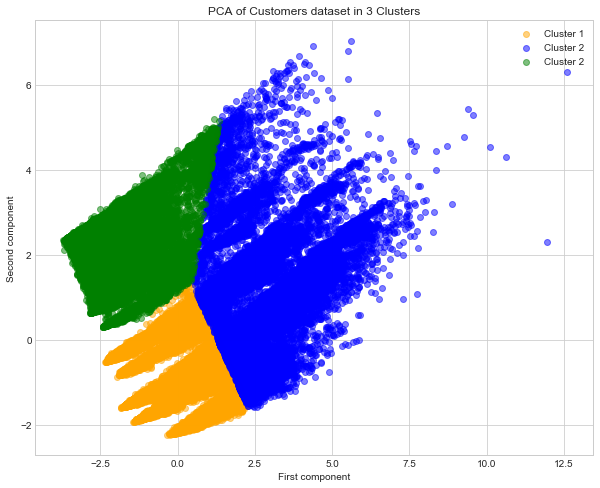

In [37]:
plt.figure(figsize = (10,8))

plt.scatter(principal_components[clusters == 0, 0], principal_components[clusters == 0, 1], alpha=.5, 
            color = 'orange', label='Cluster 1')

plt.scatter(principal_components[clusters == 1, 0], principal_components[clusters == 1, 1], alpha=.5, 
            color = 'blue', label='Cluster 2')

plt.scatter(principal_components[clusters == 2, 0], principal_components[clusters == 2, 1], alpha=.5, 
            color = 'green', label='Cluster 2')

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('PCA of Customers dataset in 3 Clusters')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


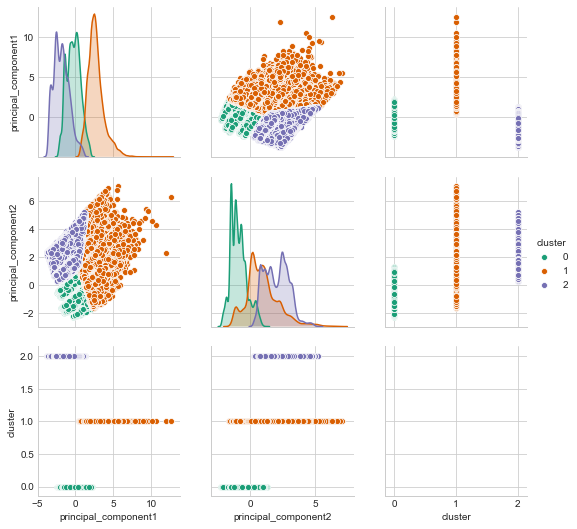

In [38]:
# visualising the pairplot by their clusters
pca_df['cluster'] = clusters

# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(pca_df, hue='cluster', palette= 'Dark2', diag_kind='kde');

### Adding the clusters to the initial dataset

In [39]:
# concatenate the cluster numbers to the initial dataset
final_dataset=pd.concat([filtered_dataset,pd.DataFrame({"cluster":clusters})],axis=1)

##### performing exploratory analysis on the final_dataset based on clusters

In [40]:
# grouping by cluster
clusterGroup=final_dataset.groupby("cluster")

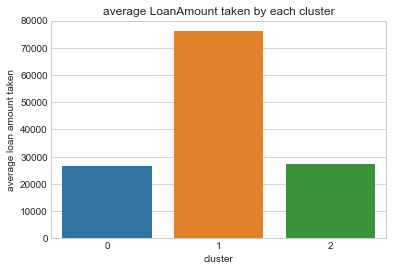

In [41]:
# finding the average LoanAmount taken by each cluster
loanAmountPerCluster=clusterGroup['loanAmount'].mean()
sns.barplot(loanAmountPerCluster.index,loanAmountPerCluster.values)
plt.title("average LoanAmount taken by each cluster")
plt.ylabel("average loan amount taken")
plt.show()

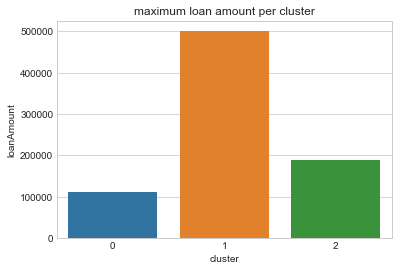

In [42]:
# finding the maximum loan amount taken by each cluster
maxLoanPerCluster=clusterGroup['loanAmount'].max()
sns.barplot(maxLoanPerCluster.index,maxLoanPerCluster.values)
plt.title("maximum loan amount per cluster")
plt.ylabel("loanAmount")
plt.show()

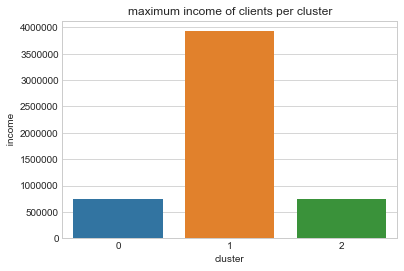

In [43]:
# finding the maximum income per cluster
incomePerCluster=clusterGroup['clientIncome'].max()
sns.barplot(incomePerCluster.index,incomePerCluster.values)
plt.ylabel(" income")
plt.title("maximum income of clients per cluster")
plt.show()

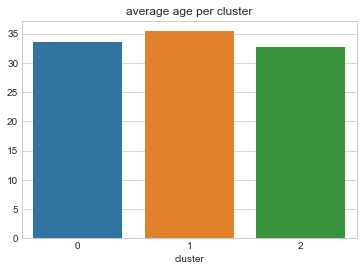

In [44]:
# average age per cluster
agePerCluster=clusterGroup['clientAge'].mean()
sns.barplot(agePerCluster.index,agePerCluster.values)
plt.title("average age per cluster")
plt.show()

Text(0.5, 1.0, 'average loan term per cluster')

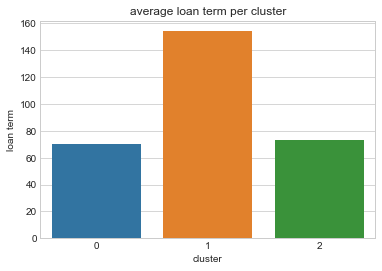

In [45]:
# average loan term per cluster
loanTermPerCluster=clusterGroup['loanTerm'].mean()
sns.barplot(loanTermPerCluster.index,loanTermPerCluster.values)
plt.ylabel("loan term")
plt.title("average loan term per cluster")

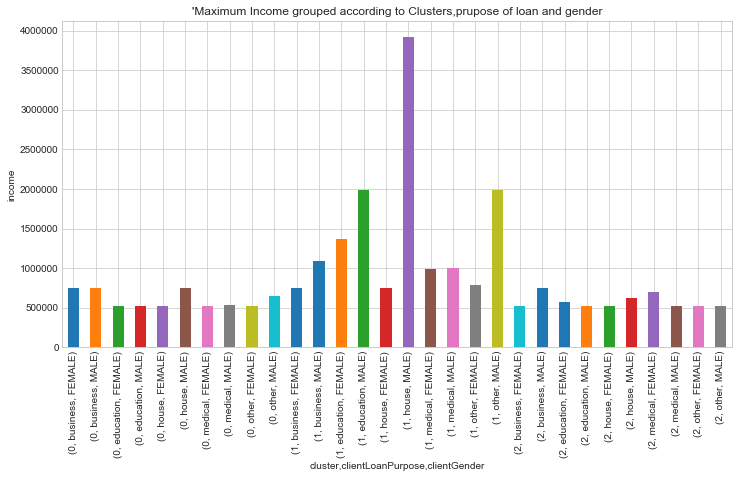

In [46]:
fig, ax = plt.subplots(figsize=(12,6))
final_dataset.groupby(["cluster","clientLoanPurpose","clientGender"])["clientIncome"].max().plot(ax=ax,kind='bar')
plt.ylabel("income")
plt.title("'Maximum Income grouped according to Clusters,prupose of loan and gender")
plt.show()

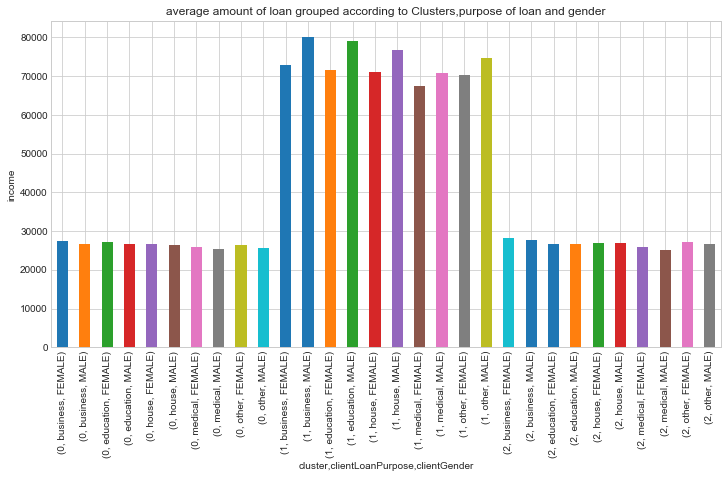

In [47]:
fig, ax = plt.subplots(figsize=(12,6))
final_dataset.groupby(["cluster","clientLoanPurpose","clientGender"])["loanAmount"].mean().plot(ax=ax,kind='bar')
plt.ylabel("income")
plt.title("average amount of loan grouped according to Clusters,purpose of loan and gender")
plt.show()

In [48]:
pd.value_counts(dataset['clientResidentialStauts'])

Rented               100534
Own Residence         26406
Family Owned          25668
Employer Provided      5589
Temp. Residence         263
Name: clientResidentialStauts, dtype: int64

# Creation of  models for prediction of loan defaulters

- reading of the dataset and splitting it

In [49]:
# reading in the dataset again so as to create a pipeline to cleanse the data and run the model easily on a new batch of data
# also done so as to mimick data coming from the wild

model_dataset=dataset=pd.read_csv("finalChallenge.csv")

# seperate the target variable from the features
target=model_dataset['loanDefault']
features=model_dataset.drop('loanDefault',axis=1)

In [50]:
# splitting the data at the initial point in order to prevent model bias and information leakage
# the test size is set to 0.1 because the entire dataset is still going to be split again and we need sufficient size to train the model
# the test_dataset here would never be touched again until the final test of the model

train_features,final_test_features,train_target,final_test_target=train_test_split(features,target,test_size=.35)
print("Train data size:",train_features.shape)
print("Train data size:",train_target.shape)

print("\nFinal test data size",final_test_features.shape)
print("Final test data size",final_test_target.shape)

Train data size: (103737, 33)
Train data size: (103737,)

Final test data size (55859, 33)
Final test data size (55859,)


### taking a look at the distribution of the training data based on the target variable in the dataset

In [51]:
pd.value_counts(train_target)

0    74696
1    29041
Name: loanDefault, dtype: int64

- There are about twice as many values of target 0 as there are for target 1.so we augument the loan-defaulters category by replicating each loan defaulters feature twice so as to make the trained model unbiased to class '0'

In [52]:
# get all the clients who defaulted their loans
loan_defaulters=train_features[train_target==1]

# add all the clients who defaulted to the training dataset again
# we have replicated the records of the clients who defaulted
balanced_train_features=np.vstack([train_features,loan_defaulters,loan_defaulters])
balanced_train_target=list(train_target)+list([1]*(len(loan_defaulters)*2))

display(pd.value_counts(balanced_train_target))

# the balancing operation returns a list, so the list has to be converted to a dataframe
balanced_train_features=pd.DataFrame(balanced_train_features,columns=train_features.columns)
balanced_train_features.sample(2)

1    87123
0    74696
dtype: int64

,id,firstDate,repaidDate,settleDays,firstPaymentRatio,firstPaymentDefault,clientId,clientIncome,incomeVerified,clientAge,...,declinedDate,disbursementDate,payout_status,dueDate,paidAt,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken
44958,302838580,2018-03-28 12:00:00 UTC,2018-06-01 07:22:38 UTC,65,0,1,45091874,35000,FALSE,42,...,Null,2/26/2018,SUCCESS,2018-04-27 02:16:02 UTC,2018-09-03 09:16:05 UTC,15000,20,60,1,1
111071,3.0222E+11,2018-09-15 12:00:00 UTC,Null,159,0.821429,1,290911806,20000,FALSE,27,...,Null,8/16/2018,SUCCESS,2018-10-15 05:42:47 UTC,Null,12000,20,60,0,1


- now as we can see the classes are balanced

## creating the random forest model

* creation of a pipeline for cleansing and preparing the data of random forest model

In [53]:
# to create a pipeline for cleansing our data we will be using a class and including some packages from sklearn
# this will enable us to bundle our data cleanser and model into a model and run it in one function call
# this cleanser is for preprocessing the dataset we will need for the random forest model
# in this class we will bundle up all of the cleaning methods we implemented above in one function
# all the cleansing methods used in this class has been explained  up above

class forestModelCleanser(BaseEstimator,TransformerMixin):
#     def __init__(self):
# #         importing pandas here incase at runtime its not available in the environment
#             return self
    def fit(self,X,y=None):
        
        return self
    
    def transform(self,X):
#         making a copy of the dataset pased into it so as to make changes without any consequence
        data=X.copy()
        #converting from string the dateTime
        data['repaidDate']=pd.to_datetime(data['repaidDate'],errors="coerce")
        data["applicationDate"]=pd.to_datetime(data["applicationDate"],errors="coerce")
        data["dueDate"]=pd.to_datetime(data["dueDate"],errors="coerce")


#         # converting from string to numeric data
        data['clientAvgCallsPerDay']=pd.to_numeric(data['clientAvgCallsPerDay'],errors="coerce")
        data['clientTimeAtEmployer'].apply(lambda number:number.replace("+",""))#replacing '+'with space for easy conversion to number e.g its impossible to parse 36+ as an integeer
        data['clientTimeAtEmployer']=pd.to_numeric(data['clientTimeAtEmployer'],errors="coerce")
        data['clientNumberPhoneContacts']=pd.to_numeric(data['clientNumberPhoneContacts'],errors="coerce")
        
        # dropping of all forms of id's since it's unique and provides no insight into the data
        data.drop(['id',"clientId","loanId"],axis=1,inplace=True)


        # dropping of redundant and repeated values
        data.drop(['dueDate',"applicationDate"],inplace=True,axis=1)#temporary#########################################
        data.drop(['payout_status',"repaidDate",'loanType',"paidAt","settleDays","firstDate",'approvalDate',"declinedDate","disbursementDate"],axis=1,inplace=True) 
        
        #dealing with null values
        treshold=(90/100)*len(data)
        data=data.applymap(lambda x: np.nan if x=="Null" else x)

        #drop columns not having at least {tresh} number of non-null values
        data=data.dropna(axis=1,thresh=treshold) 
        #fill all rows containing nulls with the values before the
        data=data.fillna(method="ffill")
        data=data.fillna(method="bfill")
        
        #random forests are suited to low dimensional non-sparse data this ["one","two","three"] is encoded as [0,1,2]
        #encode the categorical variables into numbers we can feed into the algorithm
        #for randomforest we use categorical encoding instead of one-hot
        data['incomeVerified']=data['incomeVerified'].map({"TRUE":1,"FALSE":0})
        data['clientGender']=data['clientGender'].map({"MALE":1,"FEMALE":0})
        data['clientMaritalStatus']=LabelEncoder().fit_transform(data['clientMaritalStatus'].values)
        data['clientLoanPurpose']=LabelEncoder().fit_transform(data['clientLoanPurpose'].values)
        data['clientState']=LabelEncoder().fit_transform(data['clientState'].values)
        data['clientResidentialStauts']=LabelEncoder().fit_transform(data['clientResidentialStauts'])
        
        return data

###### the impotrance of putting all the cleaning action in one function can be shown here as the entire data was cleaned in ine function call, thiss makes the cleaning of new data easier

- splitting of data into training and testing 

In [54]:
cleaned_data=forestModelCleanser().transform(balanced_train_features)

# splitting the data into training and testing data
train_x,test_x,train_y,test_y=train_test_split(cleaned_data,balanced_train_target,test_size=0.3)

### tuning of model parameters

In [111]:
# to get the best hyper parameter for the dataset
# we use grid search  to get the error on the test set per parameter
# we then choose the parammeter with the lowest error

# n_estimators is the number of random forests to be used by the ensemble
# max depth is a pruning technique to cut short the growth of the tree to prevent overfitting

param_grid={
    "n_estimators":[10,100,1000],
    "max_depth":[3,4,5]
}

# find the best parammeters over the train data
grid_search=GridSearchCV(RandomForestClassifier(),param_grid,cv=5)
grid_search.fit(train_x,train_y)

results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(2, 2)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

sns.heatmap(scores, xticklabels=param_grid['max_depth'], yticklabels=param_grid['n_estimators'], cmap="viridis")
plt.xlabel("max_depth")
plt.ylabel('n_estimators')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

ValueError: cannot reshape array of size 9 into shape (2,2)

### training of model using the best parameters obtained above

In [55]:
# afeter getting the best parmeters that give use the best score over cross validation
#we biuld a model using scikit learn's random forest algorithm
#n_jobs=1 means to use all the available cores on the computer, this improves model speed
#n_estimators is the number of random forests to use

classifier=RandomForestClassifier(n_jobs=1,n_estimators=20,max_depth=3)
classifier.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### accuracy of model on train and test set

- accuracy on the train set

In [56]:
# getting our model's accuracy on the train set and test set
train_score=classifier.score(train_x,train_y)
test_score=classifier.score(test_x,test_y)

print("the accuracy on the train set is:{}".format(train_score))
print("the accuracy on the test set is:{}".format(test_score))

print("\ntherefore since the scores are similar we can say that the data is not underfitted or overfitted and we have made the correct bias-variance trade off")

the accuracy on the train set is:0.8144306233612599
the accuracy on the test set is:0.8098298520990401

therefore since the scores are similar we can say that the data is not underfitted or overfitted and we have made the correct bias-variance trade off


- accuracy on the test set using cross validation over five sets

In [57]:
scores=cross_val_score(classifier,test_x,test_y)
print("the decision tree cross validation across 3 sets")
print(scores)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


the decision tree cross validation across 3 sets
[0.81109807 0.80787295 0.81150732]


### Plotting the importances of each features in the random forest decision boundary

In [58]:
columns=['firstPaymentRatio', 'firstPaymentDefault', 'clientIncome',
       'incomeVerified', 'clientAge', 'clientGender', 'clientMaritalStatus',
       'clientLoanPurpose', 'clientResidentialStauts', 'clientState',
       'clientNumberPhoneContacts', 'clientAvgCallsPerDay', 'loanNumber',
        'loanAmount', 'interestRate', 'loanTerm',
       'max_amount_taken', 'max_tenor_taken']

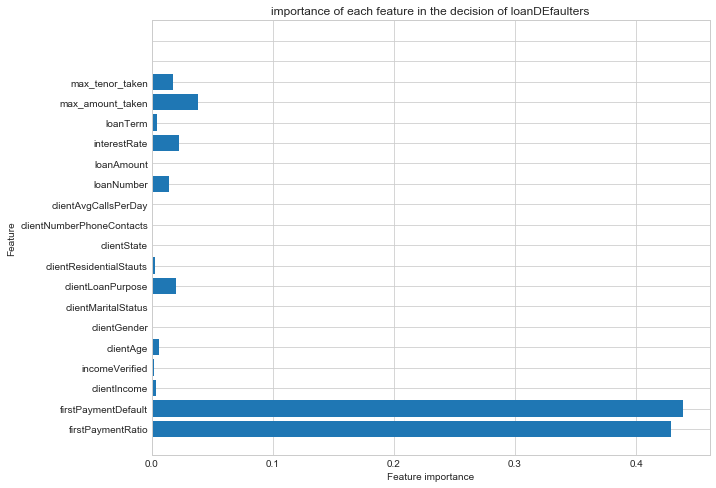

In [59]:
# when using random forests we have acesss to the 'feature_importances' property which tells us how important each feature was in the decision 
plt.figure(figsize = (10,8))

n_features = filtered_dataset.values.shape[1]    
plt.barh(range(len(classifier.feature_importances_)), classifier.feature_importances_, align='center')    
plt.yticks(np.arange(n_features),columns)   
plt.xlabel("Feature importance")    
plt.ylabel("Feature")
plt.title("importance of each feature in the decision of loanDEfaulters")
plt.show()

## Developing the neural network

- a data cleanser function to clean data in one function call

In [61]:
# to create a pipeline for cleansing our data we will be using a class and including some packages from sklearn
# this will enable us to bundle our data cleanser and model into a model and run it in one function call
# this cleanser is for preprocessing the dataset we will need for the neural network
# in this class we will bundle up all of the cleaning methods we implemented above in one function
# all the cleansing methods used in this class has been explained  up above
# it only differs by 

class NeuralNetCleanser(BaseEstimator,TransformerMixin):
    def __init__(self):
# #         importing pandas here incase at runtime its not available in the environment
          self.scaler=StandardScaler()
    def preprocess(self,X,y=None):
#         making a copy of the dataset pased into it so as to make changes without any consequence
        data=X.copy()
        #converting from string the dateTime
        data['repaidDate']=pd.to_datetime(data['repaidDate'],errors="coerce")
        data["applicationDate"]=pd.to_datetime(data["applicationDate"],errors="coerce")
        data["dueDate"]=pd.to_datetime(data["dueDate"],errors="coerce")


#         # converting from string to numeric data
        data['clientAvgCallsPerDay']=pd.to_numeric(data['clientAvgCallsPerDay'],errors="coerce")
        data['clientTimeAtEmployer'].apply(lambda number:number.replace("+",""))#replacing '+'with space for easy conversion to number e.g its impossible to parse 36+ as an integeer
        data['clientTimeAtEmployer']=pd.to_numeric(data['clientTimeAtEmployer'],errors="coerce")
        data['clientNumberPhoneContacts']=pd.to_numeric(data['clientNumberPhoneContacts'],errors="coerce")
        
        # dropping of all forms of id's since it's unique and provides no insight into the data
        data.drop(['id',"clientId","loanId"],axis=1,inplace=True)


        # dropping of redundant and repeated values
        data.drop(['dueDate',"repaidDate","applicationDate"],inplace=True,axis=1)#temporary#########################################
        data.drop(['payout_status','loanType',"paidAt","settleDays","firstDate",'approvalDate',"declinedDate","disbursementDate"],axis=1,inplace=True) 
        
        #dealing with null values
        treshold=(90/100)*len(data)
        data=data.applymap(lambda x: np.nan if x=="Null" else x)

        #drop columns not having at least {tresh} number of non-null values
        data=data.dropna(axis=1,thresh=treshold) 
        #fill all rows containing nulls
        data=data.fillna(method="ffill")
        data=data.fillna(method="bfill")

        #encode the categorical variables into one-hot variables we can feed into the algorithm
        #for neural networks the data is encoded as one-hot variables i.e 4=[0,1,0,0] 
        #thi is because neural netowrks are suited for high dimensionsal data 
        data=pd.get_dummies(data)
        
        return data
    
    def fit(self,x,y=None):
        #we have to scale the dataset as neural netwroks use a numerical optimizer 
        #which needs the data to be scaled so it can converge at a solution quickly
        
        data=self.preprocess(x)
        self.scaler=self.scaler.fit(data)
        return self
    
    def transform(self,x,y=None):
        #return the scaled version of the data after cleansing it
        data=self.preprocess(x)
        return self.scaler.transform(data)

### Designing the architecture neural network

- clean the dataset using our neural-net cleanser
- splitting our data into training and test data

In [62]:
neural_data=NeuralNetCleanser().fit_transform(balanced_train_features)
train_n_x,test_n_x,train_n_y,test_n_y=train_test_split(neural_data,balanced_train_target,test_size=0.3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [63]:
print("the initial size of the data set is:",balanced_train_features.shape)
print("the final size of the dataset after preprocessing for the neural network is:",neural_data.shape)

the initial size of the data set is: (161819, 33)
the final size of the dataset after preprocessing for the neural network is: (161819, 68)


- for the neural networks we could choose to use a number of packages such as tensorflow, keras,theano 
- but scikit learn's neural network class is used because it proveides some methods which can be used to preview what exactly the model has learned as well as provision of an easy regularization features

#### using cross grid search for optimal parameters

In [ ]:
# to get the best hyper parameter for the dataset
# we use grid search  to get the error on the test set per parameter
# we then choose the parammeter with the lowest error

# hidden_layer_sizes is the number of neurons present in the neural network

param_grid={
    "hidden_layer_sizes":[[10,10],[50,10],[100]],
    "alpha":[0.01,0.1,1]
}

# find the best parammeters over the train data
grid_search=GridSearchCV(MLPClassifierClassifier(max_iter=1000, alpha=1, random_state=0,activation="tanh"),param_grid,cv=5)
grid_search.fit(train_n_x,train_n_y)

results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(3, 3)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

sns.heatmap(scores, xticklabels=param_grid['max_depth'], yticklabels=param_grid['n_estimators'], cmap="viridis")
plt.xlabel("max_depth")
plt.ylabel('n_estimators')
plt.show()

### training of models

In [64]:
# max_iter is the maximum number of epochs the model shoould run through before it is terminated if it doeant converge
# alpha is a regularisation parameter the larger it is, the larger the regularisation is and the more constricted themodel is and the less it overfits
# using tanh as the activation function ensures l

mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0,activation="tanh") 
mlp.fit(train_n_x, train_n_y)

MLPClassifier(activation='tanh', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

- train data accuracy

In [65]:
print("Accuracy on training set: {:.3f}".format(mlp.score(train_n_x, train_n_y)))

Accuracy on training set: 0.814


- test data accuracy using cross evaluation

In [66]:
scores=cross_val_score(mlp,test_n_x,test_n_y)
print("The cross val score on the test set across 3 sets is given as ")
print(scores)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The cross val score on the test set across 3 sets is given as 
[0.8089353  0.81077741 0.81243434]


### evaluation of information learnt by the model

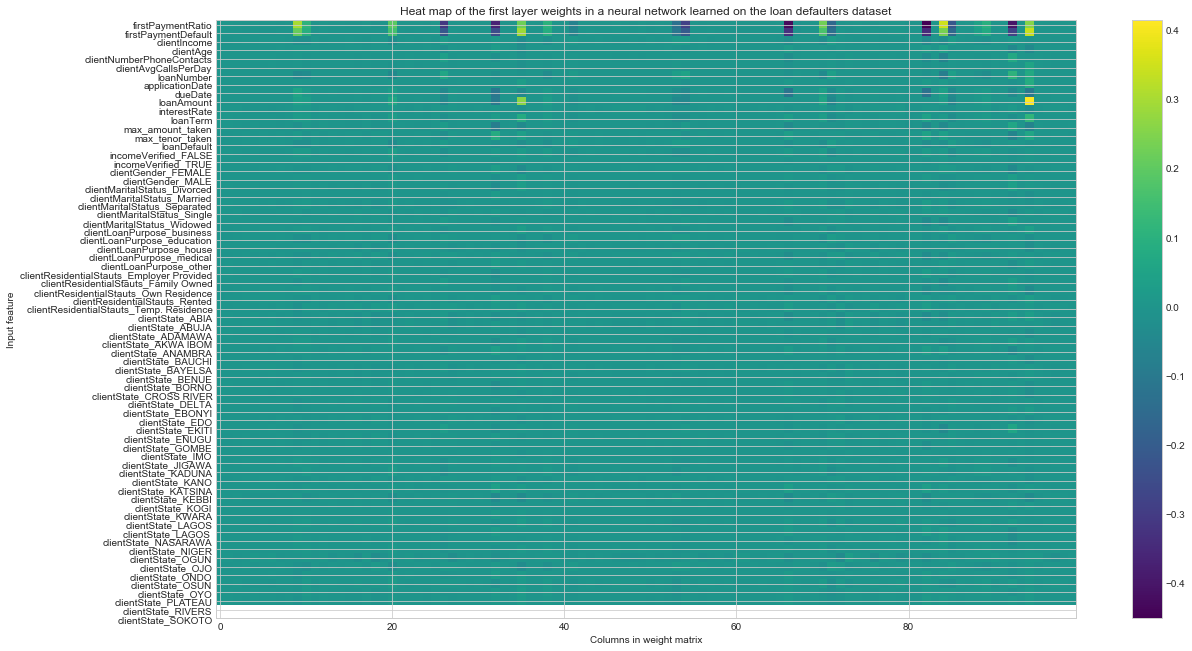

In [79]:
# Heat map of the first layer weights in a neural network learned on the loan defaulters dataset
# the higher the weight, the more important the feature
# the x-axis represents the 100 neurons present in the neural networks
columns=pd.get_dummies(filtered_dataset).columns
plt.figure(figsize=(20, 11))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis') 
plt.yticks(range(70), columns) 
plt.xlabel("Columns in weight matrix") 
plt.ylabel("Input feature")
plt.title("Heat map of the first layer weights in a neural network learned on the loan defaulters dataset")
plt.colorbar()
plt.show()

- the higher the coefficient or the lighter the patch the more important the feature

# final comparing of models 

In [80]:
# proper defination of models
forestModel=classifier
neuralNetwork=mlp

- when developing and testing the models we used accuracy
- but for binary classification especially for imbalanced datasets accuracy is not often the best measure of performance
- in this section we explore other metrics for suitable comparison

#### earlier in the very beginning we kept data aside to only use for final testing we then use the data for model comparison

- using diffferent data to compare the different models so the comparison wont be biased towards the same value

In [89]:
# transforming the dataset to fit the random forest
random_forest_data=forestModelCleanser().fit_transform(final_test_features)
forest_predicted_y=forestModel.predict(random_forest_data)
forest_actual_y=final_test_target

In [97]:
# fitting the nerual network on data it hasnt been trained on
neural_network_data=train_n_x
neural_predicted_y=neuralNetwork.predict(neural_network_data)
neural_actual_y=train_n_y

####  comparison based on confusion matrix

- random forest model

In [98]:
from sklearn.metrics import confusion_matrix

In [101]:
forest_confusion_matrix=confusion_matrix(forest_actual_y,forest_predicted_y)
print(forest_confusion_matrix)

[[35533  4697]
 [ 3994 11635]]


In [102]:
print("true negatives:",forest_confusion_matrix[0][0])
print("false positives:",forest_confusion_matrix[0][1])
print("false negatives:",forest_confusion_matrix[1][0])
print("true positives",forest_confusion_matrix[1][1])

true negatives: 35533
false positives: 4697
false negatives: 3994
true positives 11635


- neural networks

In [105]:
neural_confusion_matrix=confusion_matrix(neural_actual_y,neural_predicted_y)
print(neural_confusion_matrix)

[[45931  6258]
 [14792 46292]]


In [106]:
print("true negatives:",neural_confusion_matrix[0][0])
print("false positives:",neural_confusion_matrix[0][1])
print("false negatives:",neural_confusion_matrix[1][0])
print("true positives",neural_confusion_matrix[1][1])

true negatives: 45931
false positives: 6258
false negatives: 14792
true positives 46292


- precision recall and f1 score based comparison

In [107]:
from sklearn.metrics import classification_report

- classification report on random forest model

In [109]:
print(classification_report(forest_actual_y, forest_predicted_y,target_names=["loan repayers", "loan defaulters"]))

                 precision    recall  f1-score   support

  loan repayers       0.90      0.88      0.89     40230
loan defaulters       0.71      0.74      0.73     15629

      micro avg       0.84      0.84      0.84     55859
      macro avg       0.81      0.81      0.81     55859
   weighted avg       0.85      0.84      0.85     55859



- classification report on neural networks

In [110]:
print(classification_report(neural_actual_y, neural_predicted_y,target_names=["loan repayers", "loan defaulters"]))

                 precision    recall  f1-score   support

  loan repayers       0.76      0.88      0.81     52189
loan defaulters       0.88      0.76      0.81     61084

      micro avg       0.81      0.81      0.81    113273
      macro avg       0.82      0.82      0.81    113273
   weighted avg       0.82      0.81      0.81    113273



# overall comparison of the models

- neural networks take much longer to train as compared to random forests due to the optimization algorithm
- but they take significantly lower amount of time to train since their training operation is asum of various linear operation
- this means that the neural networks predict using a worst case scenerio of O(n)
- while the decision trees predict with a worst case of O(logn)

- idealy we want a model which is slow to train but fast at prediction time , in which neural networks take the appeal
- but the random forest has an advantage in the sense that it requires less preprocessing of data(i.e no need for one hot encoding and scaling of data) and takes a shorter time to train as well as not overfitting on the dataset since it is an ensemble method